##Instalación de librerias 

In [44]:
!pip install PyDrive

In [45]:
pip install --upgrade category_encoders

In [46]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [47]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [48]:
from google.colab import files

##Información del Data set

In [49]:
id_train_labels = '1o8fEed65R8219m5iOJoZgvHXaTGwWE4H'
id_train_values = "1RCoa3FWbpcHVC6imhaQQFQEAWNW0qkh0" 
id_test_values = '1xBGPZbt3BYxe1OOYGMJuGnXe_pEqFZ1a'
id_submission_format = "1ei8BhsAAhZpZ8sRqEOVGl12y0JAPdXGV"

downloaded_train_labels = drive.CreateFile({'id': id_train_labels})
downloaded_train_values = drive.CreateFile({'id': id_train_values})
downloaded_test_values = drive.CreateFile({'id': id_test_values})
downloaded_submission_format = drive.CreateFile({'id': id_submission_format})

downloaded_train_labels.GetContentFile('train_labels.csv')
downloaded_train_values.GetContentFile('train_values.csv')
downloaded_test_values.GetContentFile('test_values.csv')
downloaded_submission_format.GetContentFile('submission_format.csv')

In [50]:

train_values = pd.read_csv('train_values.csv', dtype={
    'building_id': 'int64', 'geo_level_1_id': 'int64',
    'geo_level_2_id': 'int64', 'geo_level_3_id': 'int64',
    'count_floors_pre_eq': 'int8', 'age': 'int32',
    'area_percentage': 'int32', 'height_percentage': 'int32',
    'land_surface_condition': 'category', 'foundation_type': 'category',
    'roof_type': 'category', 'ground_floor_type': 'category', 'other_floor_type': 'category',
    'position': 'category', 'plan_configuration': 'category', 'has_superstructure_adobe_mud': 'int8',
    'has_superstructure_mud_mortar_stone': 'int8', 'has_superstructure_stone_flag': 'int8',
    'has_superstructure_cement_mortar_stone': 'int8', 'has_superstructure_mud_mortar_brick': 'int8',
    'has_superstructure_cement_mortar_brick': 'int8', 'has_superstructure_timber': 'int8',
    'has_superstructure_bamboo': 'int8', 'has_superstructure_rc_non_engineered': 'int8',
    'has_superstructure_rc_engineered': 'int8', 'has_superstructure_other': 'int8',
    'has_superstructure_other': 'int8', 'legal_ownership_status': 'category',
    'has_secondary_use': 'bool', 'has_secondary_use_agriculture': 'bool',
    'has_secondary_use_hotel': 'bool', 'has_secondary_use_rental': 'bool',
    'has_secondary_use_institution': 'bool', 'has_secondary_use_school': 'bool',
    'has_secondary_use_industry': 'bool', 'has_secondary_use_health_post': 'bool',
    'has_secondary_use_gov_office': 'bool', 'has_secondary_use_use_police': 'bool',
    'has_secondary_use_other': 'bool', 'count_families': 'int8'
})
train_labels = pd.read_csv('train_labels.csv', dtype={
    'damage_grade': 'int16'
})

test_values = pd.read_csv('test_values.csv', dtype={
    'geo_level_1_id': 'int64',
    'geo_level_2_id': 'int64', 'geo_level_3_id': 'int64',
    'count_floors_pre_eq': 'int8', 'age': 'int32',
    'area_percentage': 'int32', 'height_percentage': 'int32'  

})

In [51]:
labels_and_values = pd.merge(
    train_labels, train_values, how='inner', on='building_id')

Agregamos Volumen


In [52]:
labels_and_values['volume_percentage'] = labels_and_values['height_percentage'] * labels_and_values['area_percentage']

In [53]:
test_values['volume_percentage'] = test_values['height_percentage'] * test_values['area_percentage']

Land surface con one hot encoding

In [54]:
labels_and_values = pd.get_dummies(labels_and_values, columns=['plan_configuration'],drop_first=True)
labels_and_values = pd.get_dummies(labels_and_values, columns=['land_surface_condition'], drop_first=True)
labels_and_values = pd.get_dummies(labels_and_values, columns=['foundation_type'], drop_first=True)

In [55]:
test_values = pd.get_dummies(test_values, columns=['plan_configuration'],drop_first=True)
test_values = pd.get_dummies(test_values, columns=['land_surface_condition'], drop_first=True)
test_values = pd.get_dummies(test_values, columns=['foundation_type'], drop_first=True)

Tratamiento de age = 995

In [56]:
labels_and_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 53 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   building_id                             260601 non-null  int64   
 1   damage_grade                            260601 non-null  int16   
 2   geo_level_1_id                          260601 non-null  int64   
 3   geo_level_2_id                          260601 non-null  int64   
 4   geo_level_3_id                          260601 non-null  int64   
 5   count_floors_pre_eq                     260601 non-null  int8    
 6   age                                     260601 non-null  int32   
 7   area_percentage                         260601 non-null  int32   
 8   height_percentage                       260601 non-null  int32   
 9   roof_type                               260601 non-null  category
 10  ground_floor_type               

In [57]:
labels_and_values = labels_and_values[labels_and_values['age']!=995]

In [58]:
damage_prediction = labels_and_values['damage_grade']

##Binary Encoding

In [59]:
encoder= ce.BinaryEncoder(cols=['geo_level_1_id','geo_level_2_id'],return_df=True)

In [60]:
encoder

BinaryEncoder(cols=['geo_level_1_id', 'geo_level_2_id'], drop_invariant=False,
              handle_missing='value', handle_unknown='value', mapping=None,
              return_df=True, verbose=0)

In [61]:
labels_and_values=encoder.fit_transform(labels_and_values) 


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [62]:
test_values=encoder.fit_transform(test_values) 

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Hacemos un split para filtrar por las columnas nuevas

In [63]:
text = "geo_level_1_id_0	geo_level_1_id_1	geo_level_1_id_2	geo_level_1_id_3	geo_level_1_id_4	geo_level_1_id_5	geo_level_2_id_0	geo_level_2_id_1	geo_level_2_id_2	geo_level_2_id_3	geo_level_2_id_4	geo_level_2_id_5	geo_level_2_id_6	geo_level_2_id_7	geo_level_2_id_8	geo_level_2_id_9	geo_level_2_id_10	geo_level_2_id_11	volume_percentage count_floors_pre_eq	age	area_percentage	height_percentage land_surface_condition_o land_surface_condition_t"
#has_superstructure_adobe_mud has_superstructure_mud_mortar_stone has_superstructure_stone_flag has_superstructure_cement_mortar_stone has_superstructure_mud_mortar_brick has_superstructure_cement_mortar_brick has_superstructure_timber has_superstructure_bamboo has_superstructure_rc_non_engineered has_superstructure_rc_engineered has_superstructure_other"
text_s = text.split()

In [64]:
labels_and_values = labels_and_values[text_s]


In [65]:
test_values = test_values[text_s]

##Separación de la variable a predecir y los features que nos interesan

**Dejamos solo las columnas que nos interesan, sin damage grade xq es lo que queremos predecir**

In [66]:
"""features = labels_and_values[["geo_level_1_id","geo_level_2_id","geo_level_3_id","area_percentage","age","height_percentage","land_surface_condition_n","land_surface_condition_o","land_surface_condition_t",'has_superstructure_adobe_mud',
    'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag','has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick', 'has_superstructure_timber','has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered', 'has_superstructure_other']]"""
#features = labels_and_values[['geo_level_1_id','geo_level_2_id','geo_level_3_id','count_floors_pre_eq','area_percentage','age','plan_configuration_a','plan_configuration_c','plan_configuration_d','plan_configuration_f','plan_configuration_m'	,'plan_configuration_n','plan_configuration_o','plan_configuration_q','plan_configuration_s','plan_configuration_u','land_surface_condition_n','land_surface_condition_o','land_surface_condition_t','has_superstructure_adobe_mud','has_superstructure_mud_mortar_stone','has_superstructure_stone_flag','has_superstructure_cement_mortar_stone','has_superstructure_mud_mortar_brick','has_superstructure_cement_mortar_brick',	'has_superstructure_timber'	,'has_superstructure_bamboo','has_superstructure_rc_non_engineered'	,'has_superstructure_rc_engineered','has_superstructure_other']]

'features = labels_and_values[["geo_level_1_id","geo_level_2_id","geo_level_3_id","area_percentage","age","height_percentage","land_surface_condition_n","land_surface_condition_o","land_surface_condition_t",\'has_superstructure_adobe_mud\',\n    \'has_superstructure_mud_mortar_stone\', \'has_superstructure_stone_flag\',\'has_superstructure_cement_mortar_stone\', \'has_superstructure_mud_mortar_brick\',\n    \'has_superstructure_cement_mortar_brick\', \'has_superstructure_timber\',\'has_superstructure_bamboo\', \'has_superstructure_rc_non_engineered\',\n    \'has_superstructure_rc_engineered\', \'has_superstructure_other\']]'

In [67]:
features = labels_and_values

Como hay muchas edificaciones que comparten geo level 1 y geo level 2 (tambien 3 pero es menos relevante que los demas) podemos promediar el daño recibido

##Creación del set de entrenamiento y test

**Dividimos train y test**


El parametro test_size es 0.2 ya que consideramos del data set el 20% para test y el 80% para el set de train

In [68]:
X_train, X_test, y_train, y_test = train_test_split(features, damage_prediction, test_size=0.15, random_state=45)

In [69]:
features.columns

Index(['geo_level_1_id_0', 'geo_level_1_id_1', 'geo_level_1_id_2',
       'geo_level_1_id_3', 'geo_level_1_id_4', 'geo_level_1_id_5',
       'geo_level_2_id_0', 'geo_level_2_id_1', 'geo_level_2_id_2',
       'geo_level_2_id_3', 'geo_level_2_id_4', 'geo_level_2_id_5',
       'geo_level_2_id_6', 'geo_level_2_id_7', 'geo_level_2_id_8',
       'geo_level_2_id_9', 'geo_level_2_id_10', 'geo_level_2_id_11',
       'volume_percentage', 'count_floors_pre_eq', 'age', 'area_percentage',
       'height_percentage', 'land_surface_condition_o',
       'land_surface_condition_t'],
      dtype='object')

In [70]:
y_train

122141    3
189366    2
41872     1
141030    3
200236    1
         ..
61285     2
137818    2
195198    3
138367    3
254224    2
Name: damage_grade, Length: 220329, dtype: int16

##XGBoost


In [71]:
XParametros = {'learning_rate' : [0.05,0.20],
               'max_depth' : [3,7],
               'min_child_weight' : [1,5],
               }

In [72]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [73]:
"""def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = True):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2)
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)[:,1]
    else:
        pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred"""

"def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, \n                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',\n                       do_probabilities = True):\n    gs = GridSearchCV(\n        estimator=model,\n        param_grid=param_grid, \n        cv=cv, \n        n_jobs=-1, \n        scoring=scoring_fit,\n        verbose=2)\n    fitted_model = gs.fit(X_train_data, y_train_data)\n    \n    if do_probabilities:\n        pred = fitted_model.predict_proba(X_test_data)[:,1]\n    else:\n        pred = fitted_model.predict(X_test_data)\n    \n    return fitted_model, pred"

In [74]:
#model = XGBClassifier(learning_rate=0.15, max_depth=11, min_child_weight=2, n_estimators=150)
model = XGBClassifier()

In [75]:
"""model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 XParametros, cv=5, scoring_fit='neg_log_loss')

print(model.best_score_)
print(model.best_params_)"""

"model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, \n                                 XParametros, cv=5, scoring_fit='neg_log_loss')\n\nprint(model.best_score_)\nprint(model.best_params_)"

In [76]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Importancia de los features para el modelo XGBoost

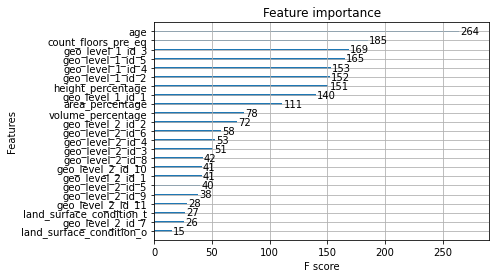

In [77]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(model)

**Predicciones**

In [78]:
predicciones = model.predict(X_test)

**Precision**

In [79]:
f1_score(predicciones, y_test, average='micro')

0.6477290262846561

In [80]:
 pred_train = model.predict(test_values)

In [81]:
pred_train

array([2, 3, 3, ..., 3, 3, 2], dtype=int16)

In [82]:
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')

In [83]:
submission_format.dtypes

damage_grade    int64
dtype: object

In [84]:
my_submission = pd.DataFrame(data=pred_train,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [85]:
my_submission.to_csv('submission.csv')

In [86]:

#files.download("submission.csv")